In [1]:
from helper_functions import *
from classes import *
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
from fold_functions import *
from plot_functions import *
import sklearn.model_selection

/home/theodoros/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the hyperparameters
DATA_DIR = 'data' # Path to the data directory
BATCH_SIZE = 32 # Batch size for the dataloaders
IN_CHANNELS = 3 # Number of input channels
HIDDEN_UNITS = 16  # Number of hidden units in the fully connected layer
NUM_CLASSES = 4 # Number of classes in the dataset
SIZE = 224 # Size of the images
LEARNING_RATE = 0.01 # Learning rate for the optimizer
EPOCHS = 20 # Number of epochs to train the model
GAMMA = 0.1 # Multiplicative factor of learning rate decay
STEP_SIZE = 6 # Step size for the learning rate scheduler
WEIGHT_DECAY = None # Weight decay for the optimizer
SEED = 1678737 # Seed for reproducibility
RANDOM_ROTATION = 10  # Random rotation for the images
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the dictionary that hold the hyperparameters
hyperparameters = {
        'BATCH_SIZE': BATCH_SIZE,
        'IN_CHANNELS': IN_CHANNELS,
        'HIDDEN_UNITS': HIDDEN_UNITS,
        'NUM_CLASSES': NUM_CLASSES,
        'SIZE': SIZE,
        'LEARNING_RATE': LEARNING_RATE,
        'EPOCHS': EPOCHS,
        'GAMMA': GAMMA,
        'STEP_SIZE': STEP_SIZE,
        'WEIGHT_DECAY': WEIGHT_DECAY,
        'SEED': SEED,
        'RANDOM_ROTATION': RANDOM_ROTATION,
        'DEVICE': DEVICE
    }

In [3]:
# Define the transforms
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomRotation(RANDOM_ROTATION),
    transforms.ToTensor(),
])

# Define the classes
classes = {
    'no_tumor': 0,
    'meningioma_tumor': 1,
    'pituitary_tumor': 2,
    'glioma_tumor': 3
}

In [4]:
walk_through_dir(DATA_DIR)

# Pre-Process the dataset
combined_dir = combine_and_rename_images(DATA_DIR,classes)

walk_through_dir(combined_dir)
# Split the dataset into train, validation, and test sets

There are 2 directories and 0 images in 'data'.
There are 4 directories and 0 images in 'data/Testing'.
There are 0 directories and 74 images in 'data/Testing/pituitary_tumor'.
There are 0 directories and 105 images in 'data/Testing/no_tumor'.
There are 0 directories and 100 images in 'data/Testing/glioma_tumor'.
There are 0 directories and 115 images in 'data/Testing/meningioma_tumor'.
There are 4 directories and 0 images in 'data/Training'.
There are 0 directories and 827 images in 'data/Training/pituitary_tumor'.
There are 0 directories and 395 images in 'data/Training/no_tumor'.
There are 0 directories and 826 images in 'data/Training/glioma_tumor'.
There are 0 directories and 822 images in 'data/Training/meningioma_tumor'.


Combining and renaming images: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

Images combined and renamed successfully.
There are 0 directories and 3264 images in 'Combined'.


In [5]:
dataset_data, dataset_labels = load_data('Combined', transform=transform)
shutil.rmtree('Combined')

Loading images: 100%|██████████| 3264/3264 [00:09<00:00, 360.08it/s]


In [6]:
# Split the dataset into train, validation, and test sets
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(dataset_data, dataset_labels, test_size=0.1, shuffle=True)

train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(train_data, train_labels, test_size=0.12, shuffle=True)

print(len(train_data), len(train_labels))
print(len(val_data), len(val_labels))
print(len(test_data), len(test_labels))

# Create the dataloaders
train_loader = DataLoader(CustomDataset(train_data, train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(CustomDataset(val_data, val_labels), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(CustomDataset(test_data, test_labels), batch_size=BATCH_SIZE, shuffle=False)

2584 2584
353 353
327 327


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained model
model = models.resnet50(pretrained=True)

# Change the grad of the model
for param in model.parameters():
    param.requires_grad = False

# Change the last layer of the model
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, NUM_CLASSES)
)

# Change the grad of the model's last layer
for param in model.fc.parameters():
    param.requires_grad = True

# Change the grad of the last Conv layer in layer4 and reset its parameters to random
for name, param in model.layer4[2].conv3.named_parameters():
    param.requires_grad = True
    if 'weight' in name:
        nn.init.kaiming_normal_(param)  # Reset the weights to random using Kaiming He initialization
    elif 'bias' in name:
        nn.init.zeros_(param)  # Reset the biases to zero

model = model.to(DEVICE)  # Replace 'cuda' with DEVICE if defined elsewhere

# Define the optimizer and the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()




/home/theodoros/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/theodoros/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
start = timer()

results = train(model,
                train_loader,
                val_loader,
                loss_fn,
                optimizer,
                EPOCHS,
                DEVICE)

end = timer()

[Epoch 6/20] Testing: 100%|██████████| 12/12 [00:15<00:00,  1.27s/it, Loss: 0.5267 | Accuracy: 81.2500%]


Saving model weights at epoch 6


[Epoch 7/20] Testing: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it, Loss: 0.5301 | Accuracy: 79.6875%]

Early stopping at epoch 7


In [9]:
print(f'Training time: {end - start}')

Training time: 956.848115883


[Epoch 1/1] Testing: 100%|██████████| 11/11 [00:13<00:00,  1.26s/it, Loss: 0.5972 | Accuracy: 75.8117%]

Evaluation results
Test Loss: 0.5972 | Test Acc: 75.81%
Class 0 - AUC: 0.96, Sensitivity: 0.69
Class 1 - AUC: 0.88, Sensitivity: 0.83
Class 2 - AUC: 0.98, Sensitivity: 0.90
Class 3 - AUC: 0.94, Sensitivity: 0.63


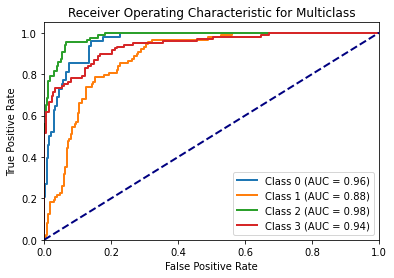

In [10]:
eval_resnet152 = evaluate(model,
                          test_loader,
                          loss_fn,
                          DEVICE)

Normalized confusion matrix


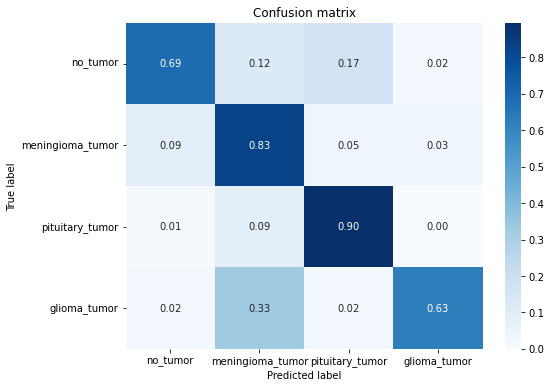

In [11]:
import numpy as np

# Assuming eval_resnet152 is the evaluation results returned by the evaluate function
y_true = eval_resnet152['all_targets']
y_pred_continuous = eval_resnet152['all_preds']

# Convert continuous predictions to discrete class labels
y_pred = np.argmax(y_pred_continuous, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with sensitivity values
plot_confusion_matrix_with_sensitivity(cm, classes, normalize=True)

<Figure size 1080x504 with 0 Axes>

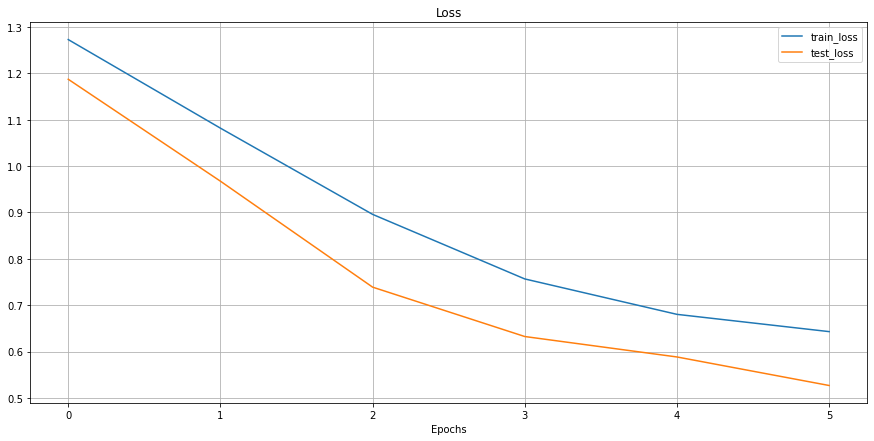

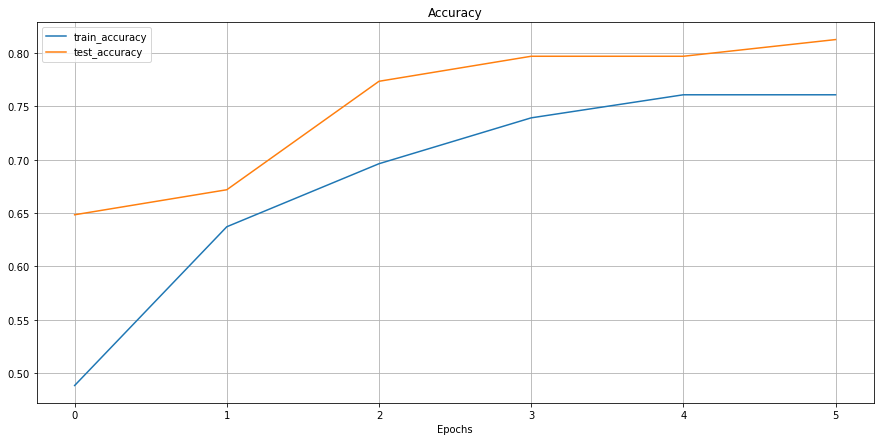

In [12]:
# Plot loss and accuracy
plot_loss_curves(results)

In [15]:
from torchvision import models
from torchsummary import summary

summary(model, (IN_CHANNELS, SIZE, SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

all_preds shape: (327, 4)
all_labels shape: (327,)
Class no_tumor - AUC: 0.96, Precision: 0.75, Recall (Sensitivity): 0.69, F1 Score: 0.72
Class meningioma_tumor - AUC: 0.88, Precision: 0.60, Recall (Sensitivity): 0.83, F1 Score: 0.70
Class pituitary_tumor - AUC: 0.98, Precision: 0.85, Recall (Sensitivity): 0.90, F1 Score: 0.87
Class glioma_tumor - AUC: 0.94, Precision: 0.94, Recall (Sensitivity): 0.63, F1 Score: 0.75


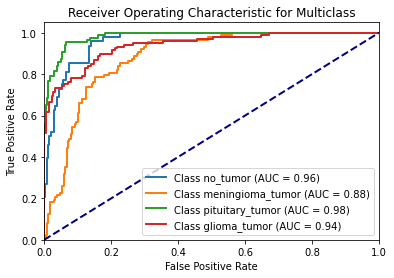

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, f1_score
import numpy as np

# Inverting the dictionary to map from indices to class names
idx_to_class = {v: k for k, v in classes.items()}

all_preds = eval_resnet152['all_preds']
all_labels = eval_resnet152['all_targets']

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f'all_preds shape: {all_preds.shape}')  # Should be (num_samples, NUM_CLASSES)
print(f'all_labels shape: {all_labels.shape}')  # Should be (num_samples,)

# Calculate ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds[:, i])
    roc_auc[i] = roc_auc_score(all_labels == i, all_preds[:, i])

# Calculate the sensitivity (recall) for each class
sensitivities = recall_score(all_labels, np.argmax(all_preds, axis=1), average=None)

# Calculate precision and F1 score for each class
precisions = precision_score(all_labels, np.argmax(all_preds, axis=1), average=None)
f1_scores = f1_score(all_labels, np.argmax(all_preds, axis=1), average=None)

# Printing the metrics with class names
for i in range(len(classes)):
    class_name = idx_to_class[i]
    print(f'Class {class_name} - AUC: {roc_auc[i]:.2f}, Precision: {precisions[i]:.2f}, '
          f'Recall (Sensitivity): {sensitivities[i]:.2f}, F1 Score: {f1_scores[i]:.2f}')

# Plotting the ROC curve for each class (optional)
import matplotlib.pyplot as plt

plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(idx_to_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()
